# Time to Fail

One of the machine learning requests that we would like to create greater visibility into and for a given test, to build a model that can predict an optimal stopping point, beyond which a test is more likely to result in a failure.

In order to achieve the above, we would be looking into the data for all the failed tests and find the distribution type for the test_duration metric. This will allow us to visualize the distribution across various testgrid dashboards and jobs. After finding out the distribution, we can find a point after which the test has a higher probability of failing.



Linked issue(s) : [Issue1](https://github.com/aicoe-aiops/ocp-ci-analysis/issues/333), [Issue2](https://github.com/aicoe-aiops/ocp-ci-analysis/issues/226)

In [1]:
import json
import gzip
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import scipy.stats
from sklearn.preprocessing import StandardScaler
from scipy.stats import invgauss, lognorm

from ipynb.fs.defs.metric_template import testgrid_labelwise_encoding
from ipynb.fs.defs.metric_template import CephCommunication
from dotenv import load_dotenv, find_dotenv
import warnings

warnings.filterwarnings("ignore")

load_dotenv(find_dotenv())

True

In [2]:
## Specify variables

METRIC_NAME = "time_to_fail"

# Specify the path for input grid data
INPUT_DATA_PATH = "../../../../data/raw/testgrid_183.json.gz"

# Specify the path for output metric data
OUTPUT_DATA_PATH = f"../../../../data/processed/metrics/{METRIC_NAME}"

## CEPH Bucket variables
## Create a .env file on your local with the correct configs
s3_endpoint_url = os.getenv("S3_ENDPOINT")
s3_access_key = os.getenv("S3_ACCESS_KEY")
s3_secret_key = os.getenv("S3_SECRET_KEY")
s3_bucket = os.getenv("S3_BUCKET")
s3_path = os.getenv("S3_PROJECT_KEY", "metrics")
s3_input_data_path = "raw_data"

# Specify whether or not we are running this as a notebook or part of an automation pipeline.
AUTOMATION = os.getenv("IN_AUTOMATION")

In [3]:
## Import data
timestamp = datetime.datetime.today()

if AUTOMATION:
    filename = f"testgrid_{timestamp.day}{timestamp.month}.json"
    cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)
    s3_object = cc.s3_resource.Object(s3_bucket, f"{s3_input_data_path}/{filename}")
    file_content = s3_object.get()["Body"].read().decode("utf-8")
    testgrid_data = json.loads(file_content)

else:
    with gzip.open(INPUT_DATA_PATH, "rb") as read_file:
        testgrid_data = json.load(read_file)

## Helper Functions

In [4]:
# Function to filter the df for a specified test
def filter_test_type(df, test):
    failures_test = df[df["test"] == test]
    failures_test = failures_test.reset_index(drop=True)
    return failures_test

In [5]:
def standardize(df, column, pct, pct_lower):
    """
    Function to standardize the features by removing the mean
    and scaling to unit variance using StandardScaler library.

    Returns standandardized feature, length of the feature
    and the original feature.
    """
    sc = StandardScaler()
    y = df[column][df[column].notnull()].to_list()
    y.sort()
    len_y = len(y)
    y = y[int(pct_lower * len_y) : int(len_y * pct)]
    len_y = len(y)
    yy = [[x] for x in y]
    sc.fit(yy)
    y_std = sc.transform(yy)
    y_std = y_std.flatten()
    return y_std, len_y, y

In [6]:
def fit_distribution(df, column, pct, pct_lower):
    """
    This function helps to list out the chi-square statistics for each
    distribution and further sorts them to find the best distribution.

    Returns a table that contains sorted chi-square values.
    """
    # Set up list of candidate distributions to use
    y_std, size, y_org = standardize(df, column, pct, pct_lower)
    dist_names = [
        "weibull_min",
        "norm",
        "weibull_max",
        "beta",
        "invgauss",
        "uniform",
        "gamma",
        "expon",
        "lognorm",
        "pearson3",
        "triang",
    ]

    chi_square_statistics = []

    # 50 bins
    percentile_bins = np.linspace(0, 100, 50)
    percentile_cutoffs = np.percentile(y_std, percentile_bins)
    observed_frequency, bins = np.histogram(y_std, bins=percentile_cutoffs)
    cum_observed_frequency = np.cumsum(observed_frequency)

    # Loop through candidate distributions
    for distribution in dist_names:
        # Set up distribution and get fitted distribution parameters
        dist = getattr(scipy.stats, distribution)
        param = dist.fit(y_std)
        print("{}\n{}\n".format(dist, param))

        # Get expected counts in percentile bins
        # cdf of fitted distribution across bins
        cdf_fitted = dist.cdf(percentile_cutoffs, *param)
        expected_frequency = []
        for bin in range(len(percentile_bins) - 1):
            expected_cdf_area = cdf_fitted[bin + 1] - cdf_fitted[bin]
            expected_frequency.append(expected_cdf_area)

        # Chi-square Statistics
        expected_frequency = np.array(expected_frequency) * size
        cum_expected_frequency = np.cumsum(expected_frequency)
        ss = scipy.stats.chisquare(
            f_obs=cum_observed_frequency, f_exp=cum_expected_frequency
        )
        chi_square_statistics.append(ss)

    # Sort by minimum ch-square statistics
    results = pd.DataFrame()
    results["Distribution"] = dist_names
    results["chi_square and p-value"] = chi_square_statistics
    results.sort_values(["chi_square and p-value"], inplace=True)

    print("\nDistributions listed by Betterment of fit:")
    print("............................................")
    print(results)

## Calculation

In [7]:
# We will now fetch all the tests which are failing i.e. have a status code of 12.
failures_list = testgrid_labelwise_encoding(testgrid_data, 12, overall_only=False)

In [8]:
# Convert to dataframe
failures_df = pd.DataFrame(
    failures_list,
    columns=["timestamp", "tab", "grid", "test", "test_duration", "failure"],
)
failures_df.head()

,timestamp,tab,grid,test,test_duration,failure
0,2021-08-25 14:51:42,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,NaN,False
1,2021-08-23 00:01:04,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,95.300000,False
2,2021-08-22 08:53:17,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,101.800000,False
3,2021-08-20 23:21:32,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,134.833333,False
4,2021-08-20 15:57:36,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,109.833333,False


In [9]:
len(failures_df)

36046950

In [10]:
# We will drop all the rows having NaN values
failures_df = failures_df.dropna()
len(failures_df)

19749103

In [11]:
# We will now filter the df for extracting only the tests that are failing
failures_df = failures_df[failures_df["failure"]]
len(failures_df)

156752

In [12]:
failures_df.head()

,timestamp,tab,grid,test,test_duration,failure
8,2021-08-16 23:03:14,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,20.016667,True
10,2021-08-16 00:01:05,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,108.233333,True
22,2021-08-16 23:03:14,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,operator.Run multi-stage test e2e-metal-assist...,13.166667,True
24,2021-08-16 00:01:05,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,operator.Run multi-stage test e2e-metal-assist...,89.983333,True
38,2021-08-16 00:01:05,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,TestInstall_test_install.start_install_and_wai...,60.004001,True


### Probability Distribution of Data
Data Distribution is a function that lists out all possible values the data can take. It can be a continuous or discrete data distribution. Several known standard Probability Distribution functions provide probabilities of occurrence of different possible outcomes in an experiment. Some well-known probability distributions are Normal, Log-Normal, Beta, Gamma, etc. which have a standard form.

We will try to approximate the distributions of the `test_duration` variable and also check its Goodness of fit for different TestGrid tests across all TestGrid dashboards and grids. Based on the type of distribution identified, we can calculate the probability of the test failing.

Let's see what are the common failing test types and identify the distribution for the top 3 test types.

In [13]:
failures_df["test"].value_counts()

Overall                                                                                                                                                                                                                                                                                                                                                                                         26525
openshift-tests.Monitor cluster while tests execute                                                                                                                                                                                                                                                                                                                                              4706
openshift-tests.[sig-arch][Feature:ClusterUpgrade] Cluster should remain functional during upgrade [Disruptive] [Serial]                                                                                                    

In [14]:
# Filter df for the "openshift-tests.Monitor cluster while tests execute" test
failures_test1 = filter_test_type(
    failures_df, "openshift-tests.Monitor cluster while tests execute"
)
failures_test1.head()

,timestamp,tab,grid,test,test_duration,failure
0,2021-08-18 15:43:11,"""redhat-openshift-informing""",release-openshift-origin-installer-e2e-aws-upg...,openshift-tests.Monitor cluster while tests ex...,35.766667,True
1,2021-08-18 15:43:11,"""redhat-openshift-informing""",release-openshift-origin-installer-e2e-aws-upg...,openshift-tests.Monitor cluster while tests ex...,53.200000,True
2,2021-08-18 14:56:49,"""redhat-openshift-informing""",release-openshift-origin-installer-e2e-aws-upg...,openshift-tests.Monitor cluster while tests ex...,37.316667,True
3,2021-08-18 14:56:48,"""redhat-openshift-informing""",release-openshift-origin-installer-e2e-aws-upg...,openshift-tests.Monitor cluster while tests ex...,54.200000,True
4,2021-08-11 22:52:13,"""redhat-openshift-informing""",release-openshift-origin-installer-e2e-aws-upg...,openshift-tests.Monitor cluster while tests ex...,66.266667,True


<AxesSubplot:>

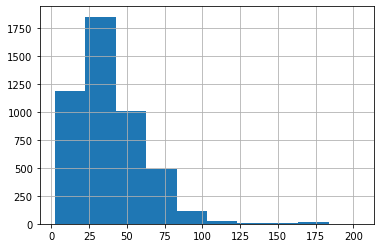

In [15]:
# Let's plot a histogram to visualize the distribution of the observed `test_duration` data points
failures_test1["test_duration"].hist()

In [16]:
# Identify the distribution
fit_distribution(failures_test1, "test_duration", 0.99, 0.01)

(1.1042279647377544, -1.5875971128993993, 1.1831443395383223)

(-9.862228386173587e-17, 1.0)

(0.599019386828437, 4.417151653057387, 1.2790196029347325)

(3.0719695238210534, 34147.571958456116, -1.5930958533087356, 17510.059923911518)

(0.35251156270290107, -1.7005070715900503, 4.823978614380098)

(-1.5875750310386525, 6.004726684096039)

(2.8845349031268146, -1.5913846768363529, 0.5516999880889919)

(-1.5875750310386525, 1.5875750310386525)

(0.5825213092113792, -1.6345728759145968, 1.3767969357933814)

(1.1775691825602044, -8.1590444380147e-17, 0.9369921331096474)

(0.1248778780900142, -1.5897056693426617, 6.0241633835378146)


Distributions listed by Betterment of fit:
............................................
   Distribution     chi_square and p-value
4      invgauss   (4646.766989051567, 0.0)
8       lognorm   (4697.511908744522, 0.0)
9      pearson3   (5880.174500310818, 0.0)
6         gamma   (5880.334295867299, 0.0)
3          beta   (6170.944934253663, 0.0)
7         expon

We see that the top 2 distributions based on betterment of fit are Inverse Gaussian distribution and Log normal distribution. Let's plot the graphs for these two distributions.

In [17]:
y_std, len_y, y = standardize(failures_test1, "test_duration", 0.99, 0.01)

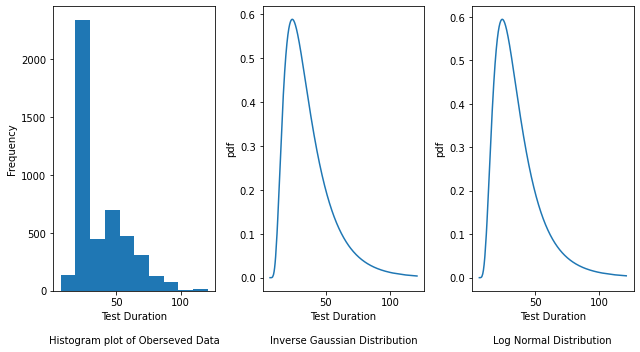

In [18]:
# Plot the distributions
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 5))
axes[0].hist(y)
axes[0].set_xlabel("Test Duration\n\nHistogram plot of Oberseved Data")
axes[0].set_ylabel("Frequency")
# Plot the density plot for Inverse Gaussian distribution by passing the mu (shape parameter), loc (location)
# and scale parameters obtained from above
axes[1].plot(y, invgauss.pdf(y_std, 0.35, -1.70, 4.82))
axes[1].set_xlabel("Test Duration\n\nInverse Gaussian Distribution")
axes[1].set_ylabel("pdf")
# Plot the density plot for Log Normal distribution by passing the mu (shape), loc (location) and
# scale parameters obtained from above
axes[2].plot(y, lognorm.pdf(y_std, 0.58, -1.63, 1.37))
axes[2].set_xlabel("Test Duration\n\nLog Normal Distribution")
axes[2].set_ylabel("pdf")
fig.tight_layout()

The Histogram plot shows the distribution of test duration values over all the data points. The Inverse Gaussian and Log Normal graphs are density plots which are a smoothed, continuous version of a histogram estimated from the data. It plots the probability density function (along Y-axis) vs the test duration values (along X-axis). Probability density plots are used to understand data distribution for a continuous variable and we want to know the likelihood (or probability) of obtaining a range of values that the continuous variable can assume. The area under the curve contains the probabilities for the test duration values.

Now, let's identify the distribution for the `openshift-tests.[sig-arch][Feature:ClusterUpgrade] Cluster should remain functional during upgrade [Disruptive] [Serial]` test

In [19]:
# Filter df for the "openshift-tests.[sig-arch][Feature:ClusterUpgrade] Cluster should remain functional during upgrade
# [Disruptive] [Serial]" test
failures_test2 = filter_test_type(
    failures_df,
    "openshift-tests.[sig-arch][Feature:ClusterUpgrade] Cluster should remain functional during upgrade [Disruptive] \
    [Serial]",
)
failures_test2.head()

,timestamp,tab,grid,test,test_duration,failure
0,2021-08-25 12:17:53,"""redhat-openshift-informing""",release-openshift-okd-installer-e2e-aws-upgrade,openshift-tests.[sig-arch][Feature:ClusterUpgr...,85.600000,True
1,2021-08-25 04:41:24,"""redhat-openshift-informing""",release-openshift-okd-installer-e2e-aws-upgrade,openshift-tests.[sig-arch][Feature:ClusterUpgr...,100.766667,True
2,2021-08-24 20:03:02,"""redhat-openshift-informing""",release-openshift-okd-installer-e2e-aws-upgrade,openshift-tests.[sig-arch][Feature:ClusterUpgr...,98.050000,True
3,2021-08-24 04:35:23,"""redhat-openshift-informing""",release-openshift-okd-installer-e2e-aws-upgrade,openshift-tests.[sig-arch][Feature:ClusterUpgr...,92.950000,True
4,2021-08-24 01:36:33,"""redhat-openshift-informing""",release-openshift-okd-installer-e2e-aws-upgrade,openshift-tests.[sig-arch][Feature:ClusterUpgr...,92.166667,True


<AxesSubplot:>

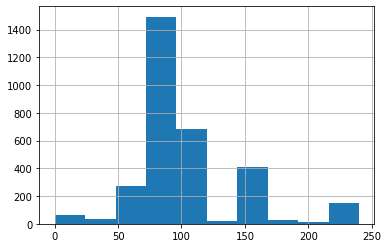

In [20]:
# Let's plot a histogram to visualize the distribution of the observed `test_duration` data points
failures_test2["test_duration"].hist()

In [21]:
# Identify the distribution
fit_distribution(failures_test2, "test_duration", 0.99, 0.01)

(2.4666409250029213, -2.429851499670257, 2.730324003150882)

(2.1940206700858674e-16, 1.0)

(0.5355423727332492, 3.4269735536094625, 1.5869343569701275)

(10.126767023068037, 323844.2286736137, -2.9681707939841058, 94950.1014663442)

(0.06184493537752664, -3.7331784362505163, 60.36352672018438)

(-2.3600801098082758, 5.787053663417738)

(10.131064867707352, -2.9565063612679223, 0.2918259243225382)

(-2.3600801098082758, 2.3600801098082758)

(0.2596785561409856, -3.5107801112747077, 3.3899163007423416)

(0.6282905320076116, 2.598344433497942e-16, 0.9288213773869954)

(0.32166229560869486, -2.400868582013486, 6.101777076749301)


Distributions listed by Betterment of fit:
............................................
   Distribution     chi_square and p-value
8       lognorm   (3414.440248564422, 0.0)
4      invgauss  (3564.6536127421323, 0.0)
9      pearson3   (3836.020406427195, 0.0)
6         gamma  (3836.1215533111454, 0.0)
3          beta   (3864.133649180025, 0.0)
0   weibull_min   

We see that the top 2 distributions based on betterment of fit are Log Normal and Inverse Gaussian distribution. Let's plot the graphs for these two distributions.

In [22]:
y_std, len_y, y = standardize(failures_test2, "test_duration", 0.99, 0.01)

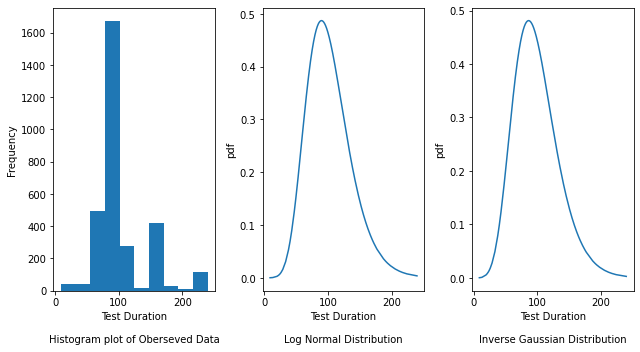

In [23]:
# Plot the distributions
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 5))
axes[0].hist(y)
axes[0].set_xlabel("Test Duration\n\nHistogram plot of Oberseved Data")
axes[0].set_ylabel("Frequency")
# Plot the density plot for Log Normal distribution by passing the mu (shape), loc (location) and
# scale parameters obtained from above
axes[1].plot(y, lognorm.pdf(y_std, 0.25, -3.51, 3.38))
axes[1].set_xlabel("Test Duration\n\nLog Normal Distribution")
axes[1].set_ylabel("pdf")
# Plot the density plot for Inverse Gaussian distribution by passing the mu (shape), loc (location) and
# scale parameters obtained from above
axes[2].plot(y, invgauss.pdf(y_std, 0.06, -3.73, 60.36))
axes[2].set_xlabel("Test Duration\n\nInverse Gaussian Distribution")
axes[2].set_ylabel("pdf")
fig.tight_layout()

The Histogram plot shows the distribution of test duration values over all the data points. The Log Normal and Inverse Gaussian graphs are density plots which are a smoothed, continuous version of a histogram estimated from the data. It plots the probability density function (along Y-axis) vs the test duration values (along X-axis). Probability density plots are used to understand data distribution for a continuous variable and we want to know the likelihood (or probability) of obtaining a range of values that the continuous variable can assume. The area under the curve contains the probabilities for the test duration values.

## Conclusion:

In this notebook, we have first filtered the testgrid for only failing tests and then plotted distribution for different TestGrid tests for the feature `test_duration`. We have observed that different TestGrid tests have different types of distribution for the test_duration. For future work, we aim to predict an optimal stopping point for each test considering the distribution type so as to make appropriate predictions.